# Imports

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import ete3
import copy
import cassiopeia as cas
%load_ext autoreload
%autoreload 2

# Helper functions for simulation

In [2]:
def simulate_imbalanced_tree(num_init_cells, init_death_prob=0.1, init_repr_prob=0.75,
                             cancer_prob=1e-3, tree_depth=15):
    num_cells = num_init_cells
    death_probs = [init_death_prob] * num_cells
    repr_probs = [init_repr_prob] * num_cells

    init_cells = [str(i) for i in np.arange(num_cells)]
    parent_ix = []
    cell_names = [np.array(init_cells)]
    repetition_coefs_list = []
    
    
    for i in range(tree_depth):
        dying = np.random.random(num_cells) < death_probs
        mutating = np.random.random(num_cells) < repr_probs

        repetition_coefs = (mutating+1)*(1-dying)

        repetition_coefs_list.append(repetition_coefs)
        next_gen = np.repeat(init_cells, repetition_coefs)

        if len(next_gen) == 0:
            raise Exception('No cells left to replicate. Terminate simulation.')
        # Label generation in terms of binary split with parents
        binary_labels = [next_gen[i]+'1' if next_gen[i-1] == next_gen[i] else
                         next_gen[i]+'0' for i in range(1, len(next_gen))]
        binary_labels = [next_gen[0]+'0'] + binary_labels
        cell_names.append(np.array(binary_labels))
        parent_ix.append(np.repeat(np.arange(num_cells), repetition_coefs))

        death_probs = np.repeat(death_probs, repetition_coefs)
        repr_probs = np.repeat(repr_probs, repetition_coefs)

        num_cells = sum(repetition_coefs)

        init_cells = binary_labels

        # Introduce cancerous mutations which may increase tumour fitness
        has_cancer = np.random.random(num_cells) < cancer_prob
        death_probs[has_cancer] -= 1e-2
        repr_probs[has_cancer] += 1e-2

    return cell_names

In [3]:
def placeholder_generate_cassettes(total_internal_nodes, cassette_size, mutation_probs=None, deletion_probs=None):
    """
    CRISPR edits are independent of each other. Each edit site has some probability of being modified or being deleted
    The only dependence between cells is that a site which has already been edited or deleted cannot be edited or deleted again

    We can a priori simulate CRISPR edits for a given number of cells and then attach these edits to cells in the lineage
    independently of one another as vector operations for speed up

    @param: num_cells (int) - Number of cells for which we should simulate CRISPR recording cassettes
    @param: cassette_size (int) - Number of sites where CRISPR edits can occur
    """

    print('THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!')

    cassette_edits = np.random.randint(low=-1, high=100, size=(total_internal_nodes, cassette_size))

    indices = np.random.choice(np.arange(cassette_edits.size), replace=False,
                               size=int(cassette_edits.size * 0.8))
    cassette_edits[np.unravel_index(indices, cassette_edits.shape)] = 0
    return (cassette_edits.tolist())

In [4]:
def get_empirical_params():
    
    import pickle
    with open('d21_indel_distributions.p', 'rb') as f:
        indel_distributions = pickle.load(f)

    speed = {'AGCTGCTTAGGGCGCAGCCT': 'slow',
         'CTCCTTGCGTTGACCCGCTT': 'slow',
         'TATTGCCTCTTAATCGTCTT': 'slow',
         'AATCCCTAGTAGATTAGCCT': 'medium',
         'CACAGAACTTTATGACGATA': 'medium',
         'TTAAGTTTGAGCTCGCGCAA': 'medium',
         'TAATTCCGGACGAAATCTTG': 'fast',
         'CTTCCACGGCTCTAGTACAT': 'fast',
         'CCTCCCGTAGTGTTGAGTCA': 'fast'
        }

    rate = {}
    rate['slow'] = 0.02361
    rate['medium'] = 0.05668
    rate['fast'] = 0.2269
    
    return speed, rate, indel_distributions


def generate_cassettes(total_internal_nodes, 
                       cassette_sites, 
                       ignore_deletions = True):
    """
    CRISPR edits are independent of each other. Each edit site has some probability of being modified or being deleted
    The only dependence between cells is that a site which has already been edited or deleted cannot be edited or deleted again

    We can a priori simulate CRISPR edits for a given number of cells and then attach these edits to cells in the lineage
    independently of one another as vector operations for speed up

    @param: total_internal_nodes: int - Number of cells for which we should simulate CRISPR recording cassettes
    @param: cassette_sites: list(str) - Guide RNAs defining the edit probabilities and indel distributions in the CRISPR cassette
    """
        
    speed, rate, indel_distributions = get_empirical_params()
    all_edits = []

    for i, site in enumerate(cassette_sites):

        #print(f'Adding {i}st/th site with speed {speed[site]}')
        # Determine the probability of a CRISPR edit occurring during a generation
        prob_edit = rate[speed[site]]
        edit_happens = (np.random.random(size=total_internal_nodes) < prob_edit).astype(int)

        indels = copy.deepcopy(indel_distributions[site])
        # Now sample which edit occurs in each cell
        del_counts = indels['']
        del indels['']
        other_counts = list(indels.values())

        counts = [del_counts] + other_counts
        counts = np.array(counts)

        potential_edits = [-1]+list(range(1,len(counts)))

        if not ignore_deletions:
            edit_probs = counts/counts.sum()
            edits = np.random.choice(potential_edits, size=total_internal_nodes, p=edit_probs)
        else:
            edit_probs = counts[1:]/counts[1:].sum()
            edits = np.random.choice(potential_edits[1:], size=total_internal_nodes, p=edit_probs)

        all_edits.append(edits*edit_happens)

    all_edits = np.vstack(all_edits)

    return all_edits.T.tolist() 

In [5]:
def generate_lineage(cell_names, cassette_edits):
    """
    Given binary names of cells in a subsample tree and corresponding CRISPR edits for each cell,
    construct a networkx graph representing parental lineages and accumulated CRISPR edits.
    """
    lineage = nx.DiGraph()
    cassette_size = len(cassette_edits[0])
    blank_cassette = [0]*cassette_size
    
    for generation, cells in enumerate(cell_names):
        for cell in cells:
            lineage.add_node(cell, generation=generation, cassette_state=np.array(blank_cassette), crispr_edit=blank_cassette)
            if len(cell) == 1:
                # Then this cell has no real parent
                lineage.add_edge("ROOT", cell)
                crispr_edit = np.array(cassette_edits.pop())
                lineage.nodes[cell]['crispr_edit'] = crispr_edit
                lineage.nodes[cell]['cassette_state'] = crispr_edit
                continue
            # Add an adge between parent node and recently added child
            parent = cell[:-1]
            lineage.add_edge(parent, cell)

            # Sample a crispr edit for this cell
            crispr_edit = np.array(cassette_edits.pop())
            # Sites which are already edited in lineage are forbidden to be edited again
            parent_state = lineage.nodes()[parent]['cassette_state']
            crispr_edit[parent_state != 0] = 0

            lineage.nodes[cell]['crispr_edit'] = crispr_edit
            lineage.nodes[cell]['cassette_state'] = crispr_edit+parent_state

    return lineage

In [6]:
def simulate_lineage(cassette_sites, num_init_cells, init_death_prob=0.1,
                     init_repr_prob=0.75, cancer_prob=1e-3, tree_depth=15):

    # Simulate tree
    cell_names = simulate_imbalanced_tree(num_init_cells=num_init_cells, init_death_prob=init_death_prob,
                                          init_repr_prob=init_repr_prob, cancer_prob=cancer_prob,
                                          tree_depth=tree_depth)

    # Generate cassette edits for each internal node
    total_internal_nodes = sum([len(x) for x in cell_names])
    cassette_edits = generate_cassettes(total_internal_nodes, cassette_sites=cassette_sites)

    # Generate networkx lineage object
    lineage = generate_lineage(cell_names, cassette_edits)
    return lineage

In [7]:
def drop_missing_data(lineage, missing_fraction):
    """
    Generate a copy of the lineage graph with missing data (represented as '-' in character matrix)
    """
    # assuming networkx tree:
    for node in lineage.nodes.values():
        if 'cassette_state' in node:
            state = list(node['cassette_state'])
            for i in range(len(state)):
                if(np.random.random() < missing_fraction):
                    state[i] = '-'
            node['cassette_state'] = state

# Run lineage tracing simulation

In [8]:

slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

cassette_sites = slow_guides+medium_guides


In [10]:
lineage = simulate_lineage(cassette_sites=cassette_sites, num_init_cells=2, init_death_prob=0.1,
                           init_repr_prob=0.75, cancer_prob=1e-3, tree_depth=5)

# for name, cell in lineage.nodes.items():
#    print(name)
#    if 'cassette_state' in cell.keys():
#        print(cell['cassette_state'])

from conversion_utils import networkx_to_ete
drop_missing_data(lineage, 0.2)
tree = networkx_to_ete(lineage)
print(tree.get_ascii())


          /-000
         |
       /00            /-001000
      |  |   /001000100
      |  |  |         \-001001
      |   \001
      |     |         /-001100
      |     |    /00110
      |      \0011    \-001101
      |         |
      |          \-00111
      |
      |               /-010000
    /0|          /01000
   |  |         |     \-010001
   |  |      /0100
   |  |     |   |     /-010010
   |  |     |    \01001
   |  |   /010        \-010011
   |  |  |  |
   |  |  |  |    /01010-010100
   |  |  |   \0101
   |  |  |      |     /-010110
   |  |  |       \01011
   |   \01            \-010111
   |     |
   |     |       /01100-011000
   |     |   /0110
   |     |  |   |     /-011010
   |     |  |    \01101
   |      \011        \-011011
   |        |
-ROOT       |         /-011100
   |         \011101110
   |                  \-011101
   |
   |                  /-100000
   |             /10000
   |            |     \-100001
   |         /1000
   |        |   |     /-100010
   | 

# Manipulating lineage graphs

In [19]:
from conversion_utils import get_ete_cm, annotate_ete_depths

def measure_imbalance(lineage):
    # assuming ete3 tree
    annotate_ete_depths(lineage)
    leaf_depths = []
    for node in lineage.get_leaves():
        leaf_depths.append(node.depth)
    return max(leaf_depths) - min(leaf_depths)


def save(lineage):
    """
    Save a copy of lineage networkx DiGraph is some easily read form
    """

    raise NotImplementedError

In [12]:
matrix = get_ete_cm(tree)
matrix

,0,1,2,3,4,5
name,,,,,,
000,0,-,0,0,0,116
001000,24,95,-,-,0,39
001001,24,95,0,-,0,0
001100,0,95,0,0,-,0
001101,0,95,0,0,0,0
00111,0,95,0,0,0,0
010000,56,95,0,-,-,0
010001,-,95,0,0,38,0
010010,56,95,-,0,0,0


# Benchmark against Cassiopeia

Cassiopeia should be able to read in both networkx trees and ete3 trees. See if you can generate some imbalanced trees, quantify how imbalanced they are (some sort of distribution of tree depths or something like that?) and record the performance of NJ vs Cassiopeia vs Scelestical

Also test these as a function of missing data 

In [13]:
from conversion_utils import convert_to_cass_cm
matrix = convert_to_cass_cm(matrix)
matrix.head()

,0,1,2,3,4,5
name,,,,,,
000,0,-1,0,0,0,116
001000,24,95,-1,-1,0,39
001001,24,95,0,-1,0,0
001100,0,95,0,0,-1,0
001101,0,95,0,0,0,0


In [14]:
# base truth tree:
truth_tree = cas.data.CassiopeiaTree(character_matrix=matrix, tree=lineage)

In [15]:
from conversion_utils import create_cass_tree
cas_tree = create_cass_tree(matrix)

In [16]:
vanilla_greedy = cas.solver.VanillaGreedySolver()
vanilla_greedy.solve(cas_tree, collapse_mutationless_edges=True)

In [17]:
rf, rf_max = cas.critique.compare.robinson_foulds(truth_tree, cas_tree)
print(rf/rf_max)
triplets = cas.critique.compare.triplets_correct(truth_tree, cas_tree, number_of_trials=500)
# print(triplets)
np.mean(list(triplets[0].values()))

0.7647058823529411


0.3356

In [322]:
from conversion_utils import networkx_to_ete, ete_to_dendropy_bare
from collections import defaultdict
from tqdm.auto import tqdm
algorithms = {"Vanilla Greedy": cas.solver.VanillaGreedySolver(),
              'UPGMA': cas.solver.UPGMASolver(dissimilarity_function=cas.solver.dissimilarity.weighted_hamming_distance),
              'NeighborJoining': cas.solver.NeighborJoiningSolver(dissimilarity_function=cas.solver.dissimilarity.weighted_hamming_distance, add_root=True)
              }



def get_cass_trees(generating_tree, taxon_namespace):
    
    # taxon_namespace = ete_to_dendropy_cm(generating_tree).taxon_namespace
    
    matrix = get_ete_cm(generating_tree)
    char_matrix = convert_to_cass_cm(matrix)    
    
    ground_truth_tree = cas.data.CassiopeiaTree(character_matrix=char_matrix, tree=generating_tree,
                                                missing_state_indicator=-1)
    from conversion_utils import add_char_meta
    add_char_meta(ground_truth_tree)
    
    trees = []
    for algorithm in algorithms.values():
        reconstructed_tree = create_cass_tree(char_matrix=char_matrix)
        algorithm.solve(reconstructed_tree)
        reconstructed_tree.collapse_mutationless_edges(infer_ancestral_characters=True)
        
        nx_tree = reconstructed_tree.get_tree_topology()
        root_name = reconstructed_tree.root
        ete_tree = networkx_to_ete(nx_tree, root_name, copy_attr=False)
        dendro_tree = ete_to_dendropy_bare(ete_tree, taxon_namespace)
        trees.append(dendro_tree)
    return tuple(trees)

from dendropy.calculate import treecompare

performance_triplets = defaultdict(list)

iterations = 20

imbalances = []
cancer_probs = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
cancer_probs = [1e-3]
rf_results = np.zeros((iterations, 6))
#fp_results = np.zeros((iterations, 6))
cancer_probs_results = []
for cancer_prob in cancer_probs:
    algorithm_to_performance_triplets = defaultdict(list)
    algorithm_to_performance_rf = defaultdict(list)
    
    
    for i in tqdm(range(iterations)):
        try:
            lineage = simulate_lineage(cassette_sites=cassette_sites, num_init_cells=2, init_death_prob=0.1,
                                       init_repr_prob=0.75, cancer_prob=cancer_prob, tree_depth=8)
        except Exception:
            print('lineage simulation failed, skipping this tree')
            continue
        drop_missing_data(lineage, 0.2)
        tree = networkx_to_ete(lineage)
        imbalance = measure_imbalance(tree)
        imbalances.append(imbalance)
        cancer_probs_results.append(cancer_prob)

        base_tree, cm = ete_to_dendropy(tree)
        taxon_namespace = cm.taxon_namespace

        vg_tree, upgma_tree, nj_tree = get_cass_trees(tree, taxon_namespace)
        w_tree, mds_tree, ll_tree = infer_lateral(base_tree, cm, dimension=8)
        trees = [vg_tree, upgma_tree, nj_tree, w_tree, mds_tree, ll_tree]
        
        for j in range(6):
            rf_results[i,j]=treecompare.weighted_robinson_foulds_distance(base_tree, trees[j])
            
#             algorithm_to_performance_triplets[algorithm_name].append(np.mean(list(triplets[0].values())))

#             algorithm_to_performance_rf[algorithm_name].append(rf / rf_max)
#     for algo in algorithms.keys():
#         performance_triplets[algo].append(np.mean(algorithm_to_performance_triplets[algo]))
#         performance_rf[algo].append(np.mean(algorithm_to_performance_rf[algo]))

  0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

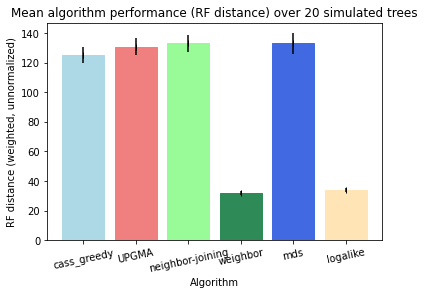

In [359]:
algo_names=["cass_greedy", "UPGMA", "neighbor-joining", "weighbor", "mds", "logalike"]
rf_means = np.mean(rf_results, axis=0)
rf_stds = np.std(rf_results, axis=0)
rf_stds *= 2/iterations
barlist = plt.bar(algo_names,rf_means)
barlist[0].set_color('lightblue')
barlist[1].set_color('lightcoral')
barlist[2].set_color('palegreen')
barlist[3].set_color('seagreen')
barlist[4].set_color('royalblue')
barlist[5].set_color('moccasin')
plt.xticks(rotation=12)
plt.xlabel("Algorithm")
plt.ylabel("RF distance (weighted, unnormalized)")
plt.title("Mean algorithm performance (RF distance) over 20 simulated trees")
plt.errorbar(algo_names, rf_means, yerr=rf_stds, fmt="|", color="black")
plt.savefig("algo_comp.png", dpi=300)
plt.show()

In [ ]:
for i in range(6):
    plt.scatter(range(iterations))

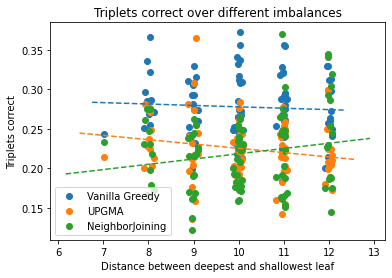

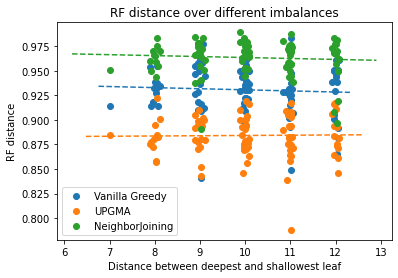

In [24]:
metric_dict = {'Triplets correct':performance_triplets, 'RF distance':performance_rf}
imbalances_jitter = imbalances + np.random.normal(scale=0.05, size=len(imbalances))
for metric, performance in metric_dict.items():
    for algo in algorithms.keys():
        plt.scatter(imbalances_jitter, performance[algo], label=algo)
        x = np.array(imbalances).reshape(-1, 1)
        y = np.array(performance[algo])
        model = LinearRegression().fit(x, y)
        line_x = np.array(plt.xlim())
        line_y = model.intercept_ + model.coef_[0] * line_x
        plt.plot(line_x, line_y, '--')

    plt.title(metric + " over different imbalances")
    plt.xlabel('Distance between deepest and shallowest leaf')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

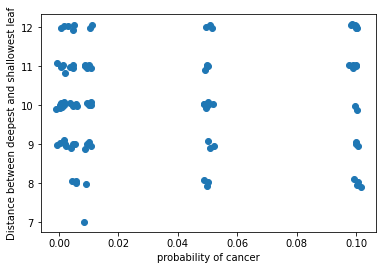

In [25]:
cancer_probs_jitter = cancer_probs_results + np.random.normal(scale=0.001, size=len(cancer_probs_results))
plt.scatter(cancer_probs_jitter, imbalances_jitter)
plt.xlabel("probability of cancer")
plt.ylabel("Distance between deepest and shallowest leaf")
plt.show()

In [298]:
lineage = simulate_lineage(cassette_sites=cassette_sites, num_init_cells=2, init_death_prob=0.1,
                           init_repr_prob=0.75, cancer_prob=1e-3, tree_depth=8)

from conversion_utils import networkx_to_ete
drop_missing_data(lineage, 0.2)
tree = networkx_to_ete(lineage)

from conversion_utils import ete_to_dendropy

import sys
sys.path.append('../lateral')  # should have lateral installed in parent directory of this file's directory
import tree_utils as l_tree_utils


from lateral_override import weighbor, cm_to_estimates, mds, logalike

from conversion_utils import ete_to_dendropy_cm, ete_labels_to_numbers
# infer using lateral. takes dendropy tree
def infer_lateral(generating_tree, cm, min_length=0.05, max_length=0.2, dimension=6, rho=0.5, v=False):
    # ete_labels_to_numbers(tree)
    
    
    for e in generating_tree.edges():
        if e.length is not None:
            e.length = np.random.rand() * (max_length - min_length) + min_length
    #cm = ete_to_dendropy_cm(tree)
    #generating_tree.taxon_namespace = cm.taxon_namespace
    #generating_tree.reroot_at_midpoint(update_bipartitions=True, suppress_unifurcations=True)
    
    # from paup import get_best_log_likelihood_for_topology, infer_tree as paup_infer_tree
    # generating_tree_ll, _ = get_best_log_likelihood_for_topology(generating_tree, cm)

    if v: print("computing distance and variance estimates")
    est_dists, variances, rates = cm_to_estimates(cm)
    
    #taxon_namespace = [taxon.label for taxon in cm.taxon_namespace]
    if v: print("computing phylogenetic distance matrix")
    est_pdm = l_tree_utils.array_to_pdm(est_dists, cm.taxon_namespace)
    
    if v: print("creating initial tree")
    sequence_length = cm.max_sequence_size
    init_tree = l_tree_utils.weighbor(est_pdm, sequence_length)
    # init_tree = weighbor(est_dists, cm.taxon_namespace, sequence_length)
    if v: print("rerooting at midpoint")
    init_tree.reroot_at_midpoint(update_bipartitions=True, suppress_unifurcations=True)
    
    #print(cm.as_string(schema="nexus",suppress_taxa_blocks=True))
    #print(init_tree.as_string(schema="nexus",suppress_taxa_blocks=True))
    
    if v: print("using PAUP to tune branch lengths")
    # import paup_override as paup
    # TODO: add RESPECTCASE argument to characters.nexus, as well as MISSING argument.
    # _, init_tree = paup.get_best_log_likelihood_for_topology(init_tree, cm)
    
    
    if v: print("using weighbor on tree")
    tree, meta = weighbor(est_dists, cm.taxon_namespace, sequence_length)
    
    if v: print("embedding tree in hyperboloid")
    ZERO_EDGE_LENGTH = 0.001
    for e in init_tree.edges():
        if e.length is not None:
            if e.length < ZERO_EDGE_LENGTH:
                e.length = ZERO_EDGE_LENGTH

    from hyperboloid_override import Hyperboloid
    hyperboloid = Hyperboloid(local_dimension=dimension, rho=0.5)
    
    vectors = hyperboloid.embed_tree(init_tree)
    initial_pts = np.array([vectors[init_tree.find_node_for_taxon(taxon)] for taxon in cm.taxon_namespace])
    
    # prevent divide-by-zero errors caused by sparse character matrix
    est_dists += 0.001
    variances += 0.001
    
    if v: print("mds")
    mds_tree, _ = mds(rho, initial_pts, est_dists, variances, hyperboloid, cm.taxon_namespace, sequence_length)
    if v: print("logalike")
    ll_tree, _ = logalike(rho, initial_pts, rates, hyperboloid, cm.taxon_namespace, sequence_length)
    
    #print(generating_tree.as_ascii_plot())
    #print(hyperbolic_tree.as_ascii_plot())
    
    assert generating_tree.taxon_namespace is ll_tree.taxon_namespace
    

    return tree, mds_tree, ll_tree

    print("comparing")
    print(treecompare.robinson_foulds_distance(generating_tree, tree))
    print(treecompare.robinson_foulds_distance(generating_tree, hyperbolic_tree))
    print(treecompare.robinson_foulds_distance(generating_tree, hyperbolic_tree2))

w_tree, mds_tree, ll_tree = infer_lateral(tree, dimension=8)

TypeError: infer_lateral() missing 1 required positional argument: 'cm'